In [1]:
from metodos.GSSL.utils.Experiments import cross_val,names

from scipy.stats import rankdata
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp


# Comparativa entre RGCLI, GBILI, KNN y SelfTraining

In [3]:

method = "rgcli"
graph_method = "transductive"

all_means = {}

for i, p in enumerate(["10", "20", "30", "40"]):
    print("PERCENTAGE:", p)
    means = []

    for name in names:
        print("\tDATASET:", name)
        m = cross_val(name, p, method=method, graph_method=graph_method)
        
        if method == "gbili" or method == "rgcli":
            np.save(f"comparativa/{method}/{graph_method}/{p}/{name}_mean.npy", np.array(m))
        else:
            np.save(f"comparativa/{method}/{p}/{name}_mean.npy", np.array(m))

        means.append(m)

    all_means[p] = np.array(means)
    
if method == "gbili" or method == "rgcli":
    np.save(f"comparativa/{method}/{graph_method}/all_means.npy", all_means)
else:
    np.save(f"comparativa/{method}/all_means.npy", all_means)
print("Resultados guardados")

PERCENTAGE: 10
	DATASET: appendicitis
		FOLD 10 - Done
		FOLD 1 - Done
		FOLD 7 - Done
		FOLD 3 - Done
		FOLD 6 - Done
		FOLD 8 - Done
		FOLD 2 - Done
		FOLD 4 - Done
		FOLD 5 - Done
		FOLD 9 - Done
	DATASET: australian
		FOLD 3 - Done
		FOLD 1 - Done
		FOLD 2 - Done
		FOLD 6 - Done
		FOLD 5 - Done
		FOLD 9 - Done
		FOLD 10 - Done
		FOLD 7 - Done
		FOLD 8 - Done
		FOLD 4 - Done
	DATASET: bupa
		FOLD 1 - Done
		FOLD 5 - Done
		FOLD 7 - Done
		FOLD 4 - Done
		FOLD 6 - Done
		FOLD 10 - Done
		FOLD 3 - Done
		FOLD 2 - Done
		FOLD 8 - Done
		FOLD 9 - Done
	DATASET: cleveland
		FOLD 7 - Done
		FOLD 10 - Done
		FOLD 1 - Done
		FOLD 4 - Done
		FOLD 5 - Done
		FOLD 2 - Done
		FOLD 9 - Done
		FOLD 3 - Done
		FOLD 8 - Done
		FOLD 6 - Done
	DATASET: contraceptive
		FOLD 1 - Done
		FOLD 4 - Done
		FOLD 8 - Done
		FOLD 5 - Done
		FOLD 7 - Done
		FOLD 6 - Done
		FOLD 3 - Done
		FOLD 2 - Done
		FOLD 9 - Done
		FOLD 10 - Done
	DATASET: dermatology
		FOLD 1 - Done
		FOLD 6 - Done
		FOLD 7 - Done
		FOLD 

## Transductive

In [4]:
import os

knn = "comparativa/knn/all_means.npy"
selftraining = "comparativa/selftraining/all_means.npy"
gbili = "comparativa/gbili/transductive/all_means.npy"
rgcli = "comparativa/rgcli/transductive/all_means.npy"

all_methods_means = {}

methods_means = []
for path in [knn, selftraining, gbili, rgcli]:
    if os.path.exists(path):
        methods_means.append(np.load(path, allow_pickle=True).item())

for i, p in enumerate(["10", "20", "30", "40"]):
    to_stack = []
    for means in methods_means:
        to_stack.append(means[p])
        
    all_methods_means[p] = np.stack(to_stack)    

all_mean_rankings = np.empty((len(methods_means), 4))

for i, p in enumerate(["10", "20", "30", "40"]):
    rankings = rankdata(-all_methods_means[p], method="average", axis=0)

    all_mean_rankings[:, i] = np.mean(rankings, axis=1)

[2.         1.95652174 2.10869565 2.10869565]
[2.34782609 2.23913043 2.         1.95652174]
[3.26086957 3.17391304 3.2173913  3.30434783]
[2.39130435 2.63043478 2.67391304 2.63043478]


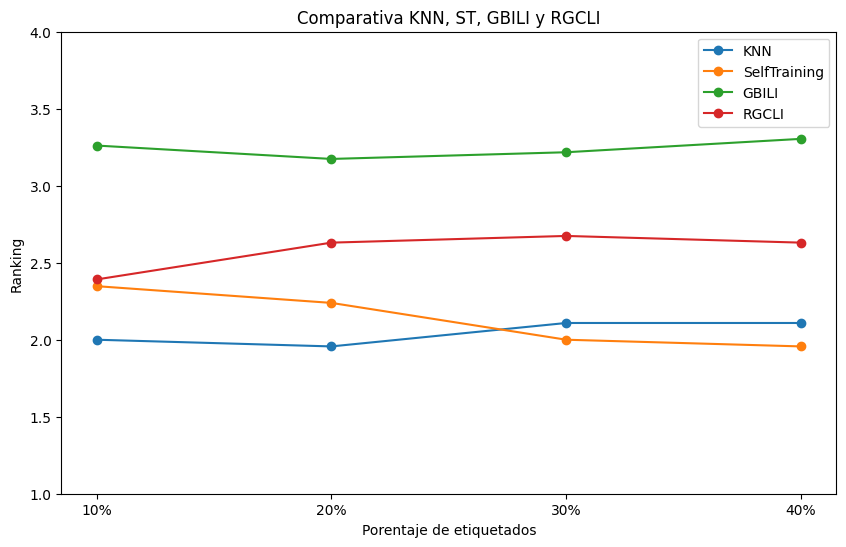

In [12]:
plt.figure(figsize=(10, 6))

classifiers = ["KNN", "SelfTraining", "GBILI", "RGCLI"]
for j, classifier in enumerate(classifiers):
    print(all_mean_rankings[j])
    plt.plot(["10%", "20%", "30%", "40%"], all_mean_rankings[j], marker="o", label=classifier)

plt.ylim(1, 4)
plt.xlabel("Porentaje de etiquetados")
plt.ylabel("Ranking")
plt.title("Comparativa KNN, ST, GBILI y RGCLI")

plt.legend()
plt.show()

In [10]:
def nemenyi_test(matrix, p, model_names):

    dict_data = {
        model_names[0]: matrix[0, :],
        model_names[1]: matrix[1, :],
        model_names[2]: matrix[2, :],
        model_names[3]: matrix[3, :]
    }
    
    data_list = [dict_data[key] for key in dict_data]

    results = np.array(data_list).T

    nemenyi_result = sp.posthoc_nemenyi_friedman(results)
    
    colors = {
        model_names[0]: "#1f77b4",
        model_names[1]: "#ff7f0e",
        model_names[2]: "#2ca02c",
        model_names[3]: "#d62728"
    }
    
    ranks = pd.DataFrame(-results).rank(axis=1, method='average').mean(axis=0)
    ranks.index = list(dict_data.keys())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(10, 2), dpi=100)
        plt.title("Nemenyi Test para " + p + " de etiquetados", pad=10)
        sp.critical_difference_diagram(ranks, nemenyi_result, label_fmt_left='{label} [{rank:.3f}]  ',
                                       label_fmt_right='  [{rank:.3f}] {label}', color_palette=colors)
        plt.show()

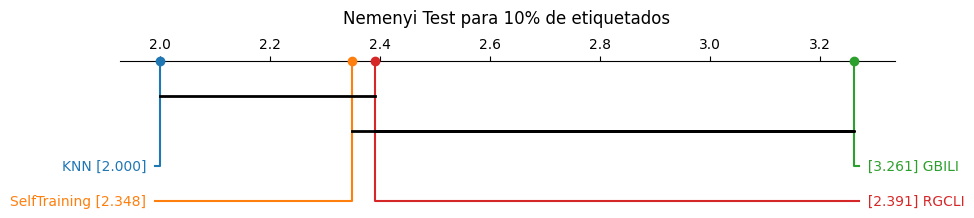

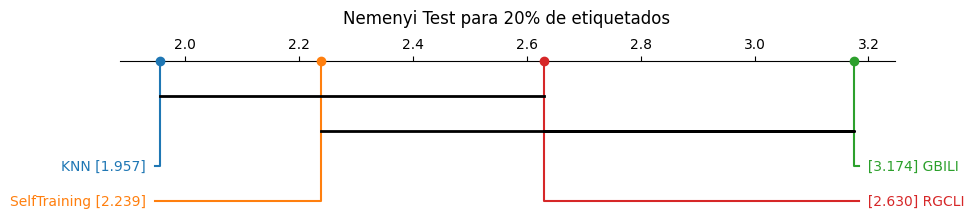

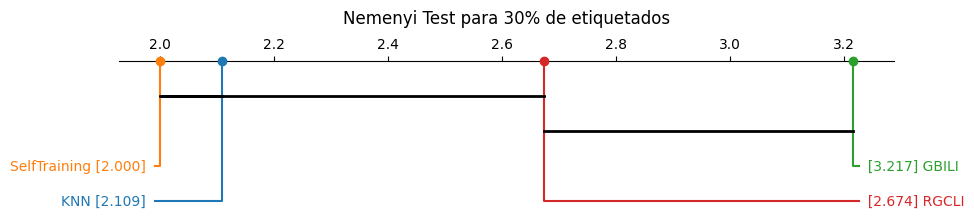

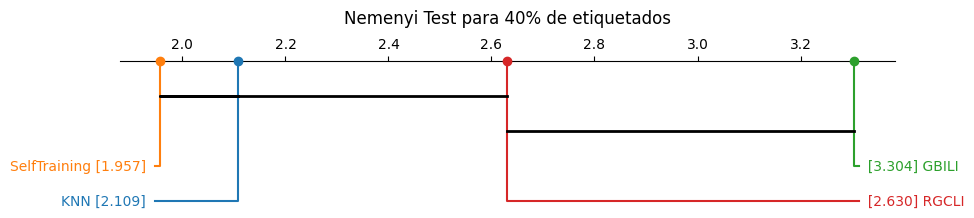

In [11]:
nemenyi_test(all_methods_means["10"], "10%", ["KNN", "SelfTraining", "GBILI", "RGCLI"])
nemenyi_test(all_methods_means["20"], "20%", ["KNN", "SelfTraining", "GBILI", "RGCLI"])
nemenyi_test(all_methods_means["30"], "30%", ["KNN", "SelfTraining", "GBILI", "RGCLI"])
nemenyi_test(all_methods_means["40"], "40%", ["KNN", "SelfTraining", "GBILI", "RGCLI"])